In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8 ])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new

PF_SIZE = 500


base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")


fixed_shrk_name = 'cov1Para'
opt_shrk_name = 'cov1Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\{opt_shrk_name}_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_rawres_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    rawres_fixed_shrk_data = pickle.load(f)

# IMPORT FACTORS DATA AND PREPARE FOR FURTHER USE
factor_path = fr"{base_folder_path}\helpers"
factors = pd.read_csv(factor_path + "/all_factors.csv")
factors = factors.pivot(index="date", columns="name", values="ret")

# as our shrk data starts from 1980-01-15 our factors data should too
start_date = str(optimal_shrk_data['date'].iloc[0])
start_date = start_date[0:4] + '-' + start_date[4:6] + "-" + start_date[6:]
start_idx = np.where(factors.index == start_date)[0][0]
factors = factors.iloc[start_idx:start_idx+fixed_shrk_data.shape[0], :]

cov1para_shrk = optimal_shrk_data['shrk_factor'].values[5040:]

len_train = 5040
end_date = fixed_shrk_data.shape[0]
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]

all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
all_factors = all_res.columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=1, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=1, min_periods=1).mean().astype(np.int64).values


params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2, optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100]  
}

X = re_hf.load_additional_train_data(**params)

### 2-layer MLP with 32 hidden neurons to estimate reward function r(s,a)

In [16]:
import torch
import torch.nn.functional as F
import torch.nn as nn


class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
    
    def forward(self, x):
        return self.layers(x)

In [15]:
from torch.utils.data import Dataset

class myDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
# define train and test
X_train, X_test = X[0:5040, :], X[5040:, :]
Y_train, Y_test = fixed_shrk_data.iloc[0:5040, 2:], fixed_shrk_data.iloc[5040:, 2:]

# train and test dataloaders

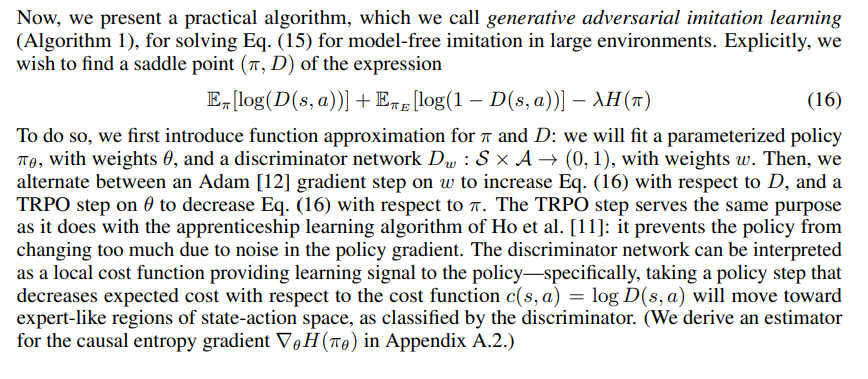

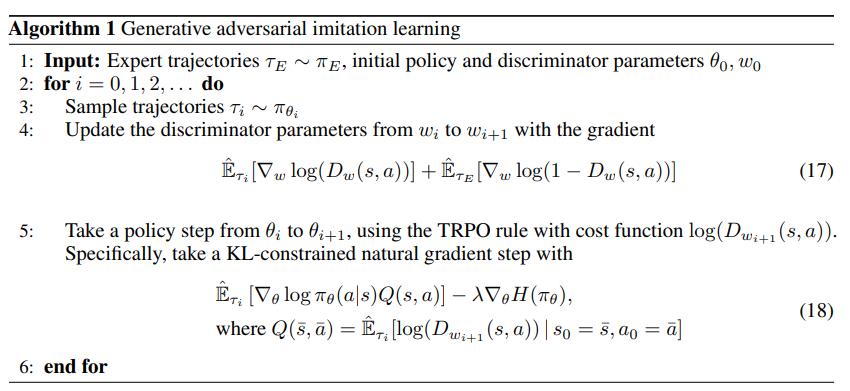


"We used all algorithms to train policies of the same neural network architecture for all tasks: two
hidden layers of 100 units each, with tanh nonlinearities in between. The discriminator networks for
Algorithm 1 also used the same architecture. All networks were always initialized randomly at the
start of each trial."

In [ ]:
# Discriminator Network
# D : S x A --> (0, 1)